In [8]:
import harp
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
from functools import reduce
import cv2
import numpy as np
import utils
import aeon.io.video as video
import aeon.analysis.movies as frame_helpers
from aeon.io.reader import Reader, Csv
from dotmap import DotMap
import aeon.io.api as aeon
import os

root_folder = r'C:/Users/neurogears/source/repos/vestibular-vr/temp_data/2024-08-23T12-51-05_B3M7/HARP/2024-08-23T12-51-05_B3M7/2024-08-23T12-51-05_B3M7/'

# h1_reader = harp.create_reader('h1-device.yml', epoch=harp.REFERENCE_EPOCH)
# h2_reader = harp.create_reader('h2-device.yml', epoch=harp.REFERENCE_EPOCH)
# session_data_reader = utils.SessionData()

# h1_datafolder = r'C:/Users/neurogears/source/repos/vestibular-vr/temp_data/2024-08-23T12-51-05_B3M7/HARP/2024-08-23T12-51-05_B3M7/2024-08-23T12-51-05_B3M7/HarpDataH1/'
# h2_datafolder = r'C:/Users/neurogears/source/repos/vestibular-vr/temp_data/2024-08-23T12-51-05_B3M7/HARP/2024-08-23T12-51-05_B3M7/2024-08-23T12-51-05_B3M7/HarpDataH2/'
# settings_datafolder = r'C:/Users/neurogears/source/repos/vestibular-vr/temp_data/2024-08-23T12-51-05_B3M7/HARP/2024-08-23T12-51-05_B3M7/2024-08-23T12-51-05_B3M7/SessionSettings/'

In [9]:
# read experiment metadata
session_settings = utils.load_json(utils.SessionData(), os.path.join(root_folder, "SessionSettings"))

print(session_settings)

                                                                     metadata
1904-01-06 01:46:41.470240  {'motorSettings': {'nominalPulseInterval': 200...


In [ ]:
# read harp streams


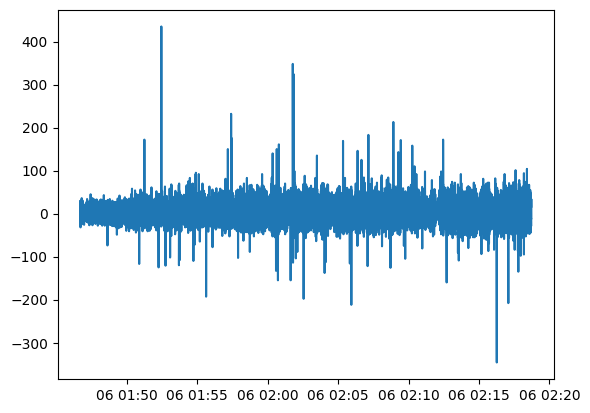

In [27]:
# read harp streams
flow_sensor = utils.load(h1_reader.OpticalTrackingRead, h1_datafolder)
analog_input = utils.load(h2_reader.AnalogInput, h2_datafolder)

plt.figure()
plt.plot(flow_sensor['OpticalTrackingRead0Y'])

In [ ]:
# read onix streams
